In [199]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from scipy.sparse import rand

# Implementing the screening rule

In [200]:
def compute_prox(x, mu):
    p = np.zeros(x.size)
    for i in range(x.size):
        if np.abs(x[i]) > mu:
            p[i] = (1 - mu / np.abs(x[i])) * x[i]
    return p

def compute_prox_subgradient(u, mu):
    g = np.zeros(u.size)
    for i in range(u.size):
        if np.abs(u[i]) > mu:
            g[i] = 1
        elif np.abs(u[i]) < mu:
            g[i] = 0
        else:
            g[i] = np.random.rand(1)[0]
    return g

def compute_loss_gradient(u, mu):
    g = np.zeros(u.size)
    for i in range(u.size):
        if np.abs(u[i]) > mu:
            g[i] = 2 * (u[i] - np.sign(u[i]) * mu)
    return g

def compute_l1_subgradient(u):
    g = np.zeros(u.size)
    for i in range(u.size):
        if u[i] != 0:
            g[i] = np.sign(u[i])
        else:
            g[i] = 2 * np.random.rand(1)[0] - 1
    return g

def compute_subgradient_old(x, D, y, lmbda, mu):
    output = D.dot(x) - y
    g_1 = compute_prox_subgradient(output, mu)
    g_1 = np.transpose(D).dot(np.diag(g_1))
    g_1 = g_1.dot(compute_prox(output, mu))
    g_2 = compute_l1_subgradient(x)
    g = g_1 + lmbda * g_2
    return g

def compute_subgradient(x, D, y, lmbda, mu):
    output = D.dot(x) - y
    g_1 = compute_loss_gradient(output, mu)
    g_1 = np.transpose(D).dot(g_1)
    g_2 = compute_l1_subgradient(x)
    g = g_1 + lmbda * g_2
    return g

def update_ellipsoid(z, A, g):
    p = z.size
    A_g = A.dot(g)
    den = np.sqrt(g.dot(A_g))
    g = (1 / den) * g
    A_g = A.dot(g)
    z = z - (1 / (p + 1)) * A_g
    A = (p ** 2 / (p ** 2 - 1)) * (A - (2 / (p + 1)) * np.outer(A_g, A_g))
    return z, A

def iterate_ellipsoids(D, y, z_init, A_init, lmbda, mu, n_steps=100):
    k = 0
    z = z_init
    A = A_init
    while k < n_steps:
        g = compute_subgradient(z, D, y, lmbda, mu)
        z, A = update_ellipsoid(z, A, g)
        k += 1 
    return z, A

def compute_test(D_i, y_i, z, A):
    test = D_i.dot(z) + np.sqrt( (D_i.dot(A.dot(D_i)))) - y_i
    return test

def compute_test_with_linear_ineq(D_i, y_i, z, A, g):
    nu = g.dot(A.dot(D_i)) / g.dot(A.dot(g))
    if nu < 0:
        test = compute_test(D_i, y_i, z, A)
    else:
        new_D_i = D_i - nu * g
        mu = np.sqrt(new_D_i.dot(A.dot(new_D_i))) / 2
        body = D_i.dot(A.dot(new_D_i)) / (2 * mu)
        test = D_i.dot(z) + body - y_i
    return test

def test_dataset(D, y, z, A, lmbda, mu, linear_ineq=True):
    results = np.zeros(D.shape[0])
    g = compute_subgradient(z, D, y, lmbda, mu)
    for i in range(D.shape[0]):
        if linear_ineq:
            test_1 = compute_test_with_linear_ineq(D[i], y[i], z, A, g)
            test_2 = compute_test_with_linear_ineq(-D[i], -y[i], z, A, g)
        else:
            test_1 = compute_test(D[i], y[i], z, A)
            test_2 = compute_test(-D[i], -y[i], z, A)
        print(test_1, test_2)
        if test_1 < mu and test_2 < mu:
            results[i] = 1
    return results

### Fitting a Lasso on remaining data

In [234]:
from sklearn.linear_model import Lasso

def find_best_lasso(X, y):
    alpha = {'alpha':[0.001,0.01,0.1,1,10]}
    clf = sklearn.model_selection.GridSearchCV(estimator = Lasso(), param_grid = alpha, cv=10)
    clf.fit(X,y)
    best_lasso = clf.best_estimator_
    return best_lasso, clf.best_score_

# Generating the data

In [235]:
#import data, real and synthetic

def make_data(param_set, noise=True):

    n = param_set[0]
    p = param_set[1]
    sparsity = param_set[2]
    X = np.zeros((n,p))
    y = np.zeros(n)
    true_params = rand(p, 1, density = sparsity).A.ravel()
    print(np.linalg.norm(true_params, ord=1))
    sparse_ones = np.zeros(p)
    for i in range(p):
        if true_params[i] != 0:
            sparse_ones[i] = 1
    true_params = 2 * true_params - sparse_ones

    noise_norm = 0

    for i in range(n):
        # sample x in [-1,1]^p box
        x = 2 * np.random.rand(p) - np.ones(p) 
        X[i,:] = x
        y[i] = np.dot(true_params,x)
        if noise:
            w = np.random.randn(1) / 10
            y[i] += w
            noise_norm = np.linalg.norm(w)

    return X, y, true_params, noise_norm

param_set = (100, 10, 0.2)
X, y, true_params, _ = make_data(param_set)

1.76522594015


# Testing the screening rule

## Synthetic dataset

In [236]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D 

# we generate the dataset, find the set X for x and execute the test.
param_set = (100, 2, 1/2)
X, y, true_params, _ = make_data(param_set)
z_init = np.zeros(2)
A_init = 2 * np.identity(2) #TODO: find rule for the radius

0.577157087567


In [237]:
lmbda = 0.001 #TODO: find rule for lmbda
mu = 0.05 #TODO: evaluate sensitivity in mu
z, A = iterate_ellipsoids(X, y, z_init, A_init, lmbda, mu)

-0.0367348258863 0.0367410143942
0.148553691224 -0.148546635757
-0.194796537868 0.194803868586
0.00797467116042 -0.00797303055843
0.016302606347 -0.0162984557308
0.0624141875788 -0.0624082019213
0.00513308749322 -0.00512658560779
-0.0793392572092 0.0793432623591
0.116682063384 -0.116677409609
-0.00544312147111 0.00544493298188
0.240359736285 -0.24035783025
-0.0711617136436 0.0711663732032
-0.0614859117732 0.0614896639242
0.150838012006 -0.150836888962
-0.0246372703781 0.02464372969
0.10390377699 -0.103897767106
-0.0703422661563 0.070343002843
0.0956925711012 -0.0956861560192
-0.110893376864 0.110898921843
-0.0754648655372 0.0754685823601
-0.0523557653192 0.0523566945163
0.0252055190644 -0.0252039007033
0.036516618928 -0.0365155738035
-0.0473379817069 0.0473390455567
0.0545059214506 -0.0545005652263
-0.042558443777 0.0425608116269
0.07067898869 -0.0706787969912
-0.0790441206151 0.0790498989794
-0.0447170141702 0.0447239272915
0.0609825311589 -0.0609763985204
0.162141401061 -0.1621358812

<IPython.core.display.Javascript object>


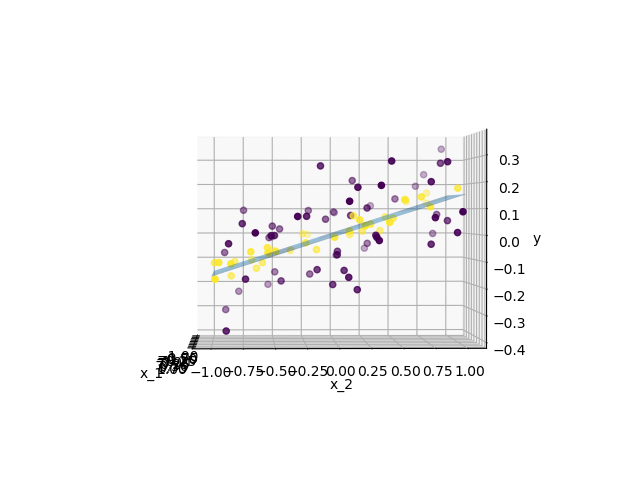

In [239]:
results = test_dataset(X, y, z, A, lmbda, mu, linear_ineq=True)
print(results, np.count_nonzero(results))

visible = True

if visible:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:,0], X[:,1], y, c=results)

    # we plot the plane from which the datapoints are generated
    x_1_true = np.linspace(-1,1,10)
    x_2_true = np.linspace(-1,1,10)
    X_1_true, X_2_true = np.meshgrid(x_1_true, x_2_true)
    y_real = true_params[0] * X_1_true + true_params[1] * X_2_true
    ax.plot_surface(X_1_true, X_2_true, y_real, alpha=0.5)
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.set_zlabel('y')
    plt.show()

The more we regularize, the lower the coefficient must be : the real model cannot be recovered and the screened points describe the plane that would be recovered using a Lasso with such lambda (to be verified). This probably explains why less datapoints are screened : since the solution that will be recovered by the Lasso with such lambda is less close to the ground truth, more points are going to pass the test (i.e prediction far from the ground truth) and not be discarded!

In [244]:
X_screened = []
y_screened = []
for i in range(X.shape[0]):
    if results[i] == 0:
        X_screened.append(X[i,:])
        y_screened.append(y[i])
X_screened = np.asarray(X_screened)
y_screened = np.asarray(y_screened)

lasso, score = find_best_lasso(X,y)
lasso_screened, screened_score = find_best_lasso(X_screened, y_screened)
print(screened_score, score)
print(lasso.coef_, lasso_screened.coef_)

0.261221118734 0.331154252155
[-0.         0.1514597] [-0.          0.12204801]


## Real dataset

### n > p

In [241]:
# Idée : appliquer la règle au dataset et voir combien de points sont écartés, quelle est la 
#sensibilité en mu, au nombre de steps de l'ellipse et à l'initialisation.

from sklearn.datasets import load_boston

boston = load_boston()
print(boston.data.shape, boston.target.shape)

z_init = np.zeros(13)
A_init = np.sqrt(13) * np.identity(13) # hyp : La solution est dans une boule de rayon sqrt(p)
lmbda = 0.1
mu = 650
z, A = iterate_ellipsoids(boston.data, boston.target, z_init, A_init, lmbda, mu)

(506, 13) (506,)


In [242]:
results = test_dataset(boston.data, boston.target, z, A, lmbda, mu, linear_ineq=True)
print(results, np.count_nonzero(results))

703.572460765 753.87551156
658.367691015 702.187305531
632.31946424 700.726177025
613.933773771 677.502459192
617.219362845 687.200975743
623.462590167 679.122385691
715.247935759 761.970845282
728.336063247 786.19689812
731.323090668 767.716288096
720.743134513 761.432434843
735.177790925 768.597368508
729.146039831 769.63107206
698.342801222 738.815043911
709.217118198 749.200616591
706.168207428 744.820251551
705.848071077 744.159739317
682.109547505 723.41135594
711.901219373 748.271608321
595.292194256 634.005800824
708.989882224 745.519007725
714.970187534 745.216108721
719.662552846 761.101925024
729.842209618 762.249676145
732.855167493 764.747050921
728.19308352 761.8890283
640.018184793 671.546027007
707.821698681 743.59369517
643.682138479 677.22147634
719.395293634 759.179047564
705.235391025 749.69119534
697.89033284 726.07383981
715.495428526 748.416794949
583.420009022 614.092435869
696.568876941 726.11404891
603.327877597 636.441312739
687.926652098 725.440613498
663.14

1157.36814113 1193.58875501
1159.19038319 1193.33204258
1162.51119135 1189.20089036
1175.29266169 1196.46788221
1124.12322892 1144.98488628
1171.85869642 1193.53491532
1167.94024215 1192.52375108
1149.94230522 1184.55849773
1166.29176201 1193.50715619
1127.12043339 1156.16718332
1174.75909284 1198.85290364
1148.1749087 1183.21662788
1109.30276188 1177.67352125
1110.67366163 1156.42506794
1049.92185687 1121.28966353
1047.83766205 1099.70618075
1038.71849497 1092.85691212
1041.02886465 1096.12745058
1073.12006532 1122.02704041
1062.32828687 1095.29530657
1051.03476748 1085.0597737
1043.9251894 1077.94619436
1052.3013889 1090.06481204
1062.66885028 1102.01859445
1035.94266521 1070.27557772
1114.07841092 1160.07844547
1113.964279 1154.09107236
1090.22405405 1144.09380683
1034.17336782 1079.98953527
1027.73695133 1069.51382212
1046.18153291 1082.65533764
1024.25517077 1061.94551826
1038.22615183 1079.95348988
1036.97137421 1075.14447783
1044.79303749 1082.24177519
1035.52599504 1082.0333033

In [243]:
X_screened = []
y_screened = []
for i in range(boston.data.shape[0]):
    if results[i] == 0:
        X_screened.append(boston.data[i,:])
        y_screened.append(boston.target[i])
X_screened = np.asarray(X_screened)
y_screened = np.asarray(y_screened)

lasso, score = find_best_lasso(boston.data,boston.target)
lasso_screened, screened_score = find_best_lasso(X_screened, y_screened)
print(screened_score, score)
print(lasso.coef_, lasso_screened.coef_)

0.274076377979 0.265093167548
[-0.09678792  0.04917922 -0.03642541  0.95709698 -0.          3.69894259
 -0.01000634 -1.16012114  0.27411189 -0.01456675 -0.77100252  0.01032665
 -0.56950927] [ -1.00563537e-01   4.80571950e-02   1.44967014e-02   2.47023319e+00
  -1.45305798e+01   3.72469617e+00   7.14459097e-03  -1.36817797e+00
   3.02622741e-01  -1.23758304e-02  -9.31742174e-01   9.77251020e-03
  -5.70718145e-01]


### n < p

In [184]:
import pandas as pd 

regular_path = '/nas/home2/g/gmialon/research/datasets/leukemia_big.csv'
laptop_path = '/Users/gregoire/Desktop/research/datasets/leukemia_big.csv'
l_data = pd.read_csv(regular_path)

def create_X_y(data):
    
    X = np.transpose(data.values)
    y_ = data.columns.values
    y = np.ones(len(y_))
    for i in range(len(y_)):
        if 'AML' in y_[i]:
            y[i] = -1
    return X, y

X, y = create_X_y(l_data)

z_init = np.zeros(X.shape[1])
A_init = np.sqrt(X.shape[0]) * np.identity(X.shape[1]) # hyp : La solution est dans une boule de rayon sqrt(n)

lmbda_grid = [1, 10, 100] # lambda does not change too much what happens (some are screened, some others not anymore)
mu_grid = [10, 1000]
n_steps_grid = [10]# a good value to screen is 5036 with radius = dim

for lmbda in lmbda_grid:
    for mu in mu_grid:
        for n_steps in n_steps_grid:
            z, A = iterate_ellipsoids(X, y, z_init, A_init, lmbda, mu, n_steps=n_steps)
            results = test_dataset(X, y, z, A, lmbda, mu)
            for i in range(10):
                print(X[i].dot(z))
            print(lmbda, mu, results)

244.676259214 246.672608578
244.676686732 246.653877676
244.676682574 246.652128749
244.675912759 246.660155782
244.676927437 246.670365232
244.676733549 246.655085756
244.676146769 246.665179543
244.675905633 246.655055065
244.676000227 246.643843675
244.676725562 246.654014269
244.676032624 246.666015662
244.675999267 246.635982079
244.676434639 246.663769836
244.676741218 246.664869008
244.676754432 246.646595993
244.676850161 246.66931372
244.676447736 246.658461736
244.675607255 246.674526327
244.676028465 246.665291064
244.675304919 246.659394914
246.676519859 244.662705422
246.67706469 244.672862254
246.675820342 244.641901594
246.676993111 244.672403723
246.676344245 244.628700529
246.67579313 244.662138551
246.67589529 244.647425592
246.676450453 244.670437719
246.676457571 244.670236637
246.676606502 244.667659795
246.674687404 244.609556385
246.676857581 244.655793769
246.676675762 244.675842196
246.676152994 244.658424768
244.677006032 246.672326078
244.676734414 246.643399

246.676561909 244.676722288
246.676811512 244.676945754
246.672497549 244.675189841
246.669394818 244.67716461
246.649249836 244.676688381
246.667522031 244.676460772
244.671410359 246.677132638
244.675456237 246.67717878
244.677145049 246.67654404
244.671134813 246.677145504
244.654549825 246.67688552
244.671105644 246.676681512
244.673979995 246.676954098
244.677001599 246.677125522
244.671170172 246.677143562
244.671218432 246.67692134
244.666121985 246.677007392
244.663467935 246.676573618
244.657538098 246.6769221
244.675378461 246.677176591
244.670704218 246.676972139
244.669874625 246.677041584
244.672282481 246.677246185
244.675244501 246.676928887
244.676481729 246.676961233
244.673912817 246.677154313
244.665829714 246.676645241
244.667496035 246.676729848
244.676440566 246.676532705
244.669935487 246.677098192
244.667873084 246.676813563
244.665143001 246.677022581
244.676985468 246.67714606
246.63157318 244.67686396
246.672531236 244.676405846
246.672204444 244.677053271
24

Question:
- Sensibilité à l'initialisation, au nombre de steps d'ellipsoides, à mu.
- Quand tout cela varie, les points éliminés le sont-ils de façon consistante => plutôt oui
- Peut-on fitter des modèles sur les points non-screenés et maintenir un bon niveau de performance? (par-rapport à une élimination random)

Y-a-t-il un scaling à faire pour Dx - y ?
Intercept ?
Essayer d'initialiser à un point proche de la solution


TODO LIST

- Expérience avec meilleure initialisation.
- Screening de features avant?
- Print test value. Quelle est leur distribution ? => semble ne pas dépendre de n_steps